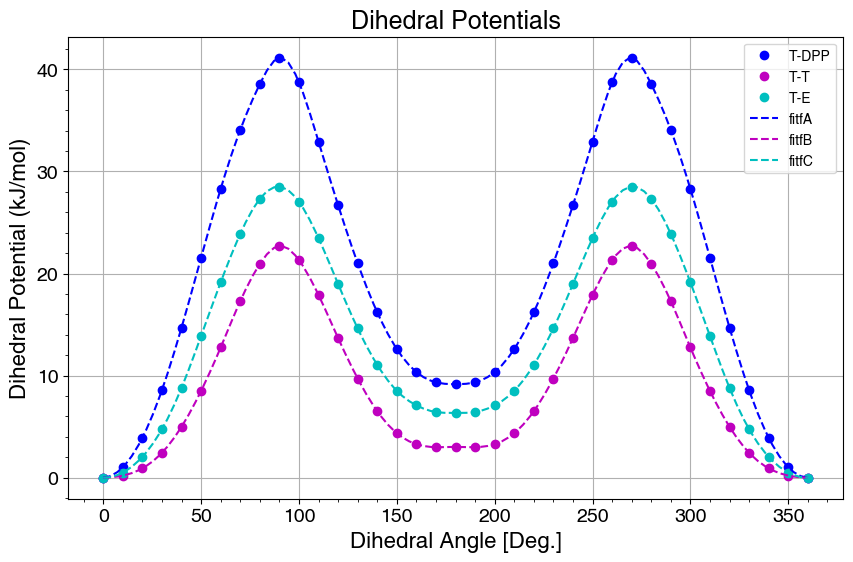

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import scipy.constants as sc
from pathlib import Path

temperature = 300  # K
kTval = sc.R * temperature / 1000 # kJ/mol

def read_data(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    mirrored = np.column_stack((-data[:, 0] + 360, data[:, 1]))
    combined = np.vstack((data, mirrored))
    combined = np.unique(combined, axis=0)
    return combined[np.argsort(combined[:, 0])]

label_a = 'T-DPP'
label_b = 'T-T'
label_c = 'T-E'
a = read_data(Path(f"{label_a}.txt"))
b = read_data(Path(f"{label_b}.txt"))
c = read_data(Path(f"{label_c}.txt"))
fitfa = interp1d(a[:, 0], a[:, 1], kind='cubic', fill_value="extrapolate")
fitfb = interp1d(b[:, 0], b[:, 1], kind='cubic', fill_value="extrapolate")
fitfc = interp1d(c[:, 0], c[:, 1], kind='cubic', fill_value="extrapolate")
# Plot the dihedral potentials
plt.figure(figsize=(10, 6))
plt.plot(a[:, 0], a[:, 1], 'bo', label=label_a)
plt.plot(b[:, 0], b[:, 1], 'mo', label=label_b)
plt.plot(c[:, 0], c[:, 1], 'co', label=label_c)
x_plot = np.linspace(0, 360, 100)
plt.plot(x_plot, fitfa(x_plot), 'b--', label='fitfA')
plt.plot(x_plot, fitfb(x_plot), 'm--', label='fitfB')
plt.plot(x_plot, fitfc(x_plot), 'c--', label='fitfC')
plt.xlabel("Dihedral Angle [Deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Potential (kJ/mol)", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.minorticks_on()
plt.title("Dihedral Potentials", fontsize=18, fontfamily="Helvetica")
plt.show()

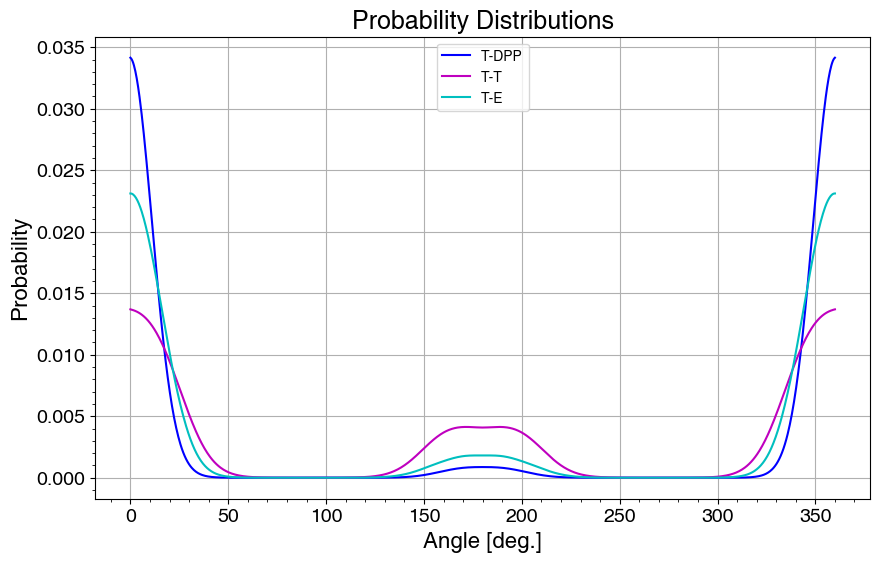

In [3]:
norm_val_a, _ = quad(lambda x: np.exp(-fitfa(x)/kTval), 0, 360)
norm_val_b, _ = quad(lambda x: np.exp(-fitfb(x)/kTval), 0, 360)
norm_val_c, _ = quad(lambda x: np.exp(-fitfc(x)/kTval), 0, 360)

# Plot probability distributions
x_values = np.linspace(0, 360, 1000)
probA_vals = np.exp(-fitfa(x_values)/kTval) / norm_val_a
probB_vals = np.exp(-fitfb(x_values)/kTval) / norm_val_b
probC_vals = np.exp(-fitfc(x_values)/kTval) / norm_val_c

plt.figure(figsize=(10, 6))
plt.plot(x_values, probA_vals, 'b-', label=label_a)
plt.plot(x_values, probB_vals, 'm-', label=label_b)
plt.plot(x_values, probC_vals, 'c-', label=label_c)
plt.xlabel("Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.minorticks_on()
plt.show()

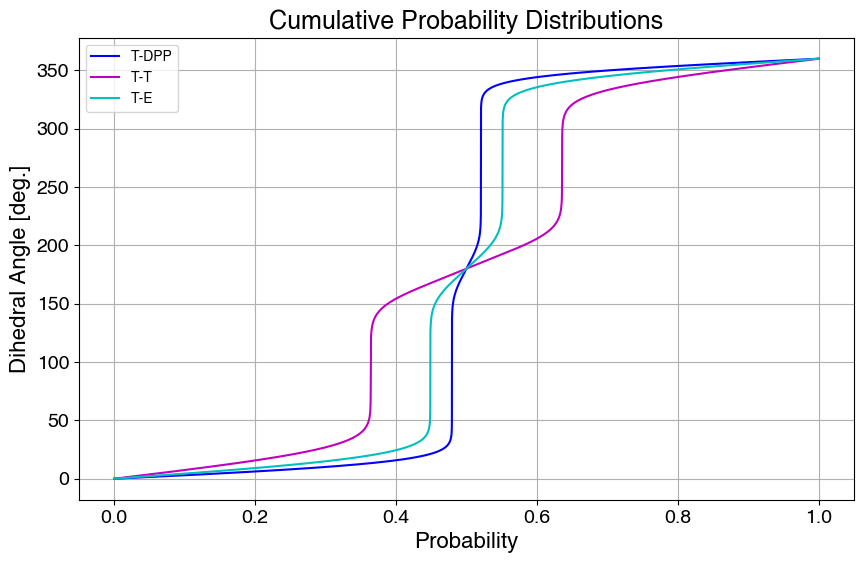

In [4]:
cum_a = cumulative_trapezoid(probA_vals, x_values, initial=0)
cum_b = cumulative_trapezoid(probB_vals, x_values, initial=0)
cum_c = cumulative_trapezoid(probC_vals, x_values, initial=0)
th_a = interp1d(cum_a/cum_a[-1], x_values, kind='cubic', fill_value="extrapolate")
th_b = interp1d(cum_b/cum_b[-1], x_values, kind='cubic', fill_value="extrapolate")
th_c = interp1d(cum_c/cum_c[-1], x_values, kind='cubic', fill_value="extrapolate")
plt.figure(figsize=(10, 6))
plt.plot(cum_a/cum_a[-1], x_values, 'b-', label=label_a)
plt.plot(cum_b/cum_b[-1], x_values, 'm-', label=label_b)
plt.plot(cum_c/cum_c[-1], x_values, 'c-', label=label_c)
plt.xlabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Cumulative Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.show()

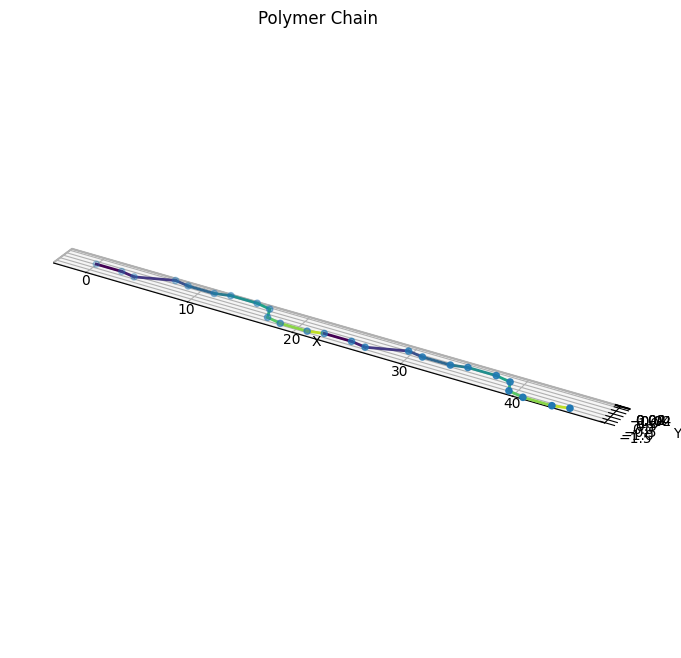

In [5]:
# molecular chain
# T-bond-DPP-bond-T-bond-T-bond-E-bond-T-bond
l = [
    2.533, 1.432, 3.533, 1.432, 2.533, 1.432, 2.533, 1.433, 1.363, 1.433,
    2.533, 1.432
]
Angle = np.deg2rad(
    np.array([
        -10.83, 30.79, -30.79, 10.83, 14.92, -14.91, -13.29, -53.16, 53.16, 13.29,
        14.91, -14.92
    ]))
length = len(l)
l_array = np.vstack((np.array([l]), np.zeros((2, length)))).T

# tested, slightly faster than scipy.spatial.transform.Rotation.from_rotvec
def rotation_matrix(axis, angle):
    """
    Return the rotation matrix associated with 
    counterclockwise rotation about the given 
    axis by angle radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


def chain(n):
    angles = np.cumsum(Angle[np.arange(n-1) % length])
    vectors = l_array[np.arange(1, n) % length]  # shape (n-1, 3)
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    rotated_x = vectors[:, 0] * cos_angles - vectors[:, 1] * sin_angles
    rotated_y = vectors[:, 0] * sin_angles + vectors[:, 1] * cos_angles
    rotated_z = vectors[:, 2] 
    segments = np.column_stack((rotated_x, rotated_y, rotated_z))    
    return np.cumsum(np.vstack((np.array([[0, 0, 0], l_array[0]]), segments)),
                     axis=0)


def drawChain(pts):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pts_array = np.array(pts)
    ax.scatter(pts_array[:, 0], pts_array[:, 1], pts_array[:, 2], s=20)
    for i in range(len(pts) - 1):
        ax.plot([pts[i][0], pts[i + 1][0]], [pts[i][1], pts[i + 1][1]],
                [pts[i][2], pts[i + 1][2]],
                color=plt.get_cmap('viridis')(i % length * (256 // length)),
                linewidth=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    # ax.view_init(elev=90, azim=0)
    plt.title("Polymer Chain")
    plt.show()


drawChain(chain(2 * length))

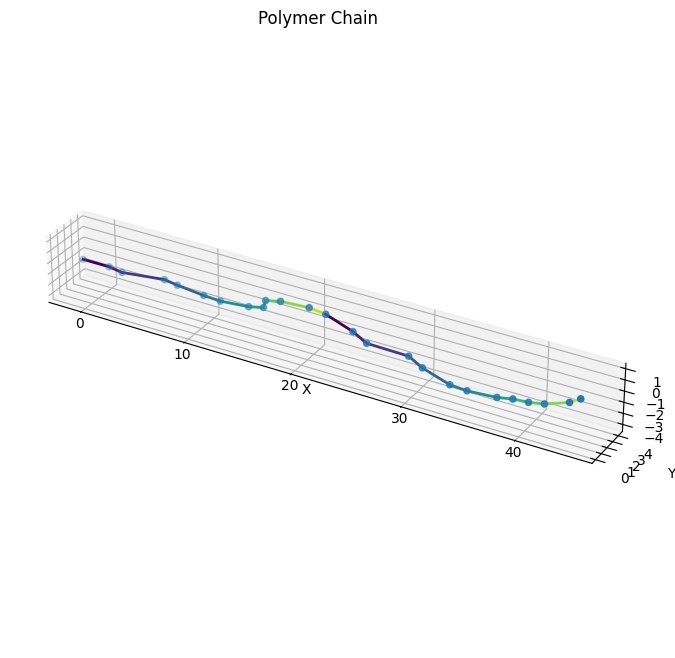

In [6]:
# index 0 and 1 is the first unit, 1 and 2 is the first linker bond
# if nb = 2, this is the end of first linker bond，rotation axis is pts[2] - pts[1] (fist linker bond vector)，
# index 3 and later points minus pts[2]，rotated，and then ad pts[2]
def dihedralRotate(pts, nb, theta_deg):
    theta_rad = np.deg2rad(theta_deg)
    vec = pts[nb] - pts[nb - 1]
    vec_norm = np.linalg.norm(vec)
    axis = vec / vec_norm
    rot = rotation_matrix(axis, theta_rad)
    pts[nb + 1:] = (pts[nb+1:] - pts[nb]) @ rot.T + pts[nb]
    return pts


def randomRotate(pts):
    newpts = pts.copy()
    k_values = np.arange(2, len(pts) - 1, 2)
    mod_k = k_values % length
    mask_a = np.isin(mod_k, [2, 4])  # th_a
    mask_b = np.isin(mod_k, [6, 0])  # th_b
    mask_c = np.isin(mod_k, [8, 10])  # th_c
    rand_a = th_a(np.random.rand(mask_a.sum()))
    rand_b = th_b(np.random.rand(mask_b.sum()))
    rand_c = th_c(np.random.rand(mask_c.sum()))
    for k, angle in zip(k_values[mask_a], rand_a):
        dihedralRotate(newpts, k, angle)
    for k, angle in zip(k_values[mask_b], rand_b):
        dihedralRotate(newpts, k, angle)
    for k, angle in zip(k_values[mask_c], rand_c):
        dihedralRotate(newpts, k, angle)

    return newpts


drawChain(randomRotate(chain(2 * length)))

In [7]:
def cosVals(pts):
    k_values = np.arange(2, len(pts), length)
    vectors = pts[k_values] - pts[k_values-1]
    v2 = vectors[0]
    dots = vectors @ v2
    norms = np.linalg.norm(vectors, axis=1) * np.linalg.norm(v2)
    return np.clip(dots/norms, -1, 1)
# Correlation function calculation
n_repeat_units = 20
chain_length = n_repeat_units * length
ch = chain(chain_length)
n_samples = 50000

def calculate_cos_vals(i):
    return cosVals(randomRotate(np.copy(ch)))

import psutil
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
n_jobs = psutil.cpu_count(logical=False)
cosList2 = Parallel(n_jobs=n_jobs, verbose=1)(delayed(calculate_cos_vals)(i) for i in range(n_samples))
corr2 = np.mean(np.array(cosList2), axis=0)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 5632 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 21632 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 44032 tasks      | elapsed:   25.5s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:   29.0s finished


logFitPrime (slope): -0.11047936650187062
Correlation length: 9.051463921845244


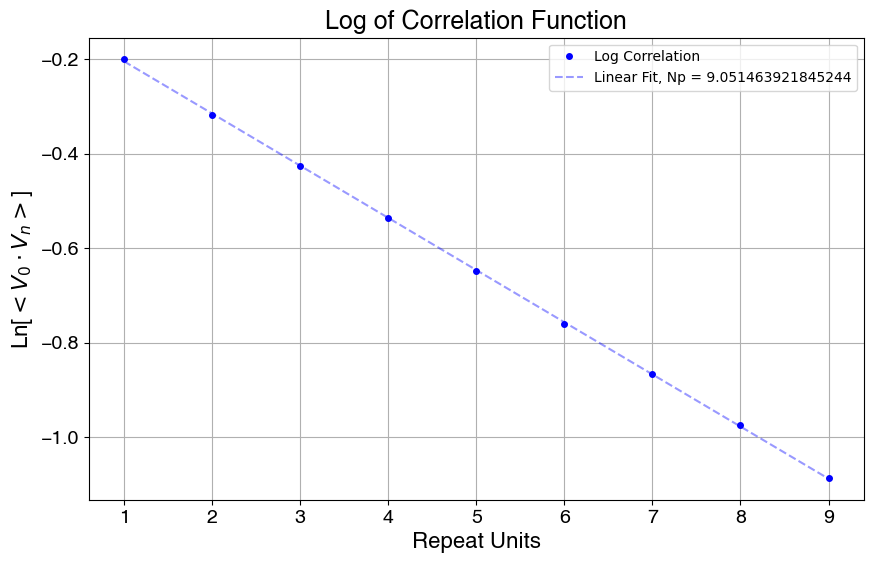

In [8]:
repeat_units = np.arange(len(corr2))


def linear_func(x, a, b):
    return a + b * x


start_idx = 1
end_idx = 10
popt, pcov = curve_fit(linear_func, repeat_units[start_idx:end_idx], np.log(corr2[start_idx:end_idx]))
logFit_prime = popt[1]
persistence_length = -1 / logFit_prime
print(f"logFitPrime (slope): {logFit_prime}")
print(f"Correlation length: {persistence_length}")

plt.figure(figsize=(10, 6))
plt.plot(repeat_units[start_idx:end_idx],
         np.log(corr2[start_idx:end_idx]),
         'bo',
         markersize=4,
         label='Log Correlation')
plt.plot(repeat_units[start_idx:end_idx],
         linear_func(repeat_units[start_idx:end_idx], *popt),
         'b--', alpha=0.4,
         label=f'Linear Fit, Np = {persistence_length}')
plt.xlabel("Repeat Units", fontsize=16, fontfamily="Helvetica")
plt.ylabel(r'Ln[$<V_0 \cdot V_n>$]',
           fontsize=16,
           fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.grid(True)
plt.legend()
plt.title("Log of Correlation Function", fontsize=18, fontfamily="Helvetica")
plt.show()